In [22]:
# Author : Rohan Singh Rajput  
# Project : Mult-Purpose Deep Learning Forecsasting Model 
# 
# 


""" This is the final term project for multipurpose forecasting model for the power using Deep learning network 
we have used the Recurrent Neural Network (RNN) using Long-Short Term Memory (LSTM), Simple RNN and GRU for the time series prediction of this project
.This project uses deep learning library TensorFlow using Keras Wrapper arround it.
"""

"""Please provide all the data accorfingly in order to run the file."""
import time
import numpy
import matplotlib.pyplot as plt

import pandas
import math
from keras.models import Sequential
from keras.callbacks import TensorBoard
from keras.layers import Dense ,Activation
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline


In [23]:
# Here intial declartion can be provided for model traning
splitfactor,prev=.80,3
#batch_size = 1
# convert an array of values into a dataset matrix
def construct(d1,prev):
	x,y,val=[],[],len(d1)-prev
	for z in range(val-1):
		x.append(d1[z:(z+prev), 0]),y.append(d1[z + prev, 0])
	return numpy.array(x), numpy.array(y)


In [24]:
# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset and normalize it, provide the size of the data included.
path = '/home/rohan/Machine_Learning_Project/hourly_2007.csv'
data_set = None
def getdata(path,data_set):
    frame = pandas.read_csv(path, engine='python',usecols=[1],nrows=data_set,skiprows=1)
    print len(frame)
#frame = pandas.read_csv(path, usecols=[2], engine='python', skipfooter=None)
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform((frame.values).astype('float32')), scaler



In [25]:
def data_modifier(d1, splitfactor,prev):
	# split into train and test sets
	data_train,data_test = int(len(d1) *splitfactor ),int(len(d1) *(1-splitfactor))

	train, test = d1[0:data_train,:], d1[data_train:len(d1),:]

	# reshape into X=t and Y=t+1
	train_X, train_Y = construct(train, prev)
	testX, testY=construct(test, prev)
   
	# reshape input to be [samples, time steps, features]
	train_X = numpy.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
	testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
	return train_X,testX, train_Y, testY
#tb = TensorBoard(log_dir='/home/gaurav/Solar_power_dnn/logs', histogram_freq=0, write_graph=True, write_images=False)
d1,scaler=getdata(path,data_set)

train_X,testX, train_Y, testY=data_modifier(d1,splitfactor,prev)
print (len(train_X),len(testX))

8759
(7003, 1748)


In [26]:

# create and fit the LSTM network
def build_model(train_X, train_Y,prev):
    model = Sequential()
    batch_size=1
    model.add(SimpleRNN(4, batch_input_shape=(batch_size,prev, 1), stateful=True, return_sequences=True))
    model.add(LSTM(6, batch_input_shape=(batch_size,prev, 1), stateful=True, return_sequences=True))
    model.add(LSTM(4,batch_input_shape=(batch_size,prev,1),stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(1):
        model.fit(train_X, train_Y, nb_epoch=20, batch_size=batch_size, verbose=2,shuffle=False)
        model.reset_states()
    return model    
model=build_model(train_X, train_Y,prev)		




Epoch 1/20
13s - loss: 0.0213
Epoch 2/20
12s - loss: 0.0106
Epoch 3/20
12s - loss: 0.0104
Epoch 4/20
12s - loss: 0.0103
Epoch 5/20
12s - loss: 0.0103
Epoch 6/20
12s - loss: 0.0102
Epoch 7/20
12s - loss: 0.0102
Epoch 8/20
12s - loss: 0.0102
Epoch 9/20
13s - loss: 0.0102
Epoch 10/20
12s - loss: 0.0102
Epoch 11/20
13s - loss: 0.0102
Epoch 12/20
12s - loss: 0.0102
Epoch 13/20
12s - loss: 0.0102
Epoch 14/20
13s - loss: 0.0102
Epoch 15/20
12s - loss: 0.0102
Epoch 16/20
13s - loss: 0.0102
Epoch 17/20
12s - loss: 0.0102
Epoch 18/20
13s - loss: 0.0102
Epoch 19/20
13s - loss: 0.0102
Epoch 20/20
13s - loss: 0.0102


In [27]:
batch_size=1
def transform(x):
	return scaler.inverse_transform(x)
# make predictions
predtr = transform(model.predict(train_X,batch_size))
predtr[predtr < 0] = 0
train_Y =  transform([train_Y])
predte,testY = transform(model.predict(testX, batch_size)),transform([testY])
predte[predte < 0] = 0

In [28]:
def err(x,x1,i):
	if i==1:
	    return math.sqrt(mean_squared_error(x, x1))
	else:
	    return mean_absolute_error(x, x1)

# calculate root mean squared error
trerr= err(train_Y[0],predtr[:,0],1)
teerr =err(testY[0], predte[:,0],1)
print 'Train Score: %.2f RMSE' %(trerr)
print 'Test Score: %.2f RMSE' % (teerr)
# calculate mean absloute error
meanerrtr = err(train_Y[0],predtr[:,0],0)
meanerrte = err(testY[0], predte[:,0],0)
print 'Train Score: %.2f MAE' %(meanerrtr)
print 'Test Score: %.2f MAE' % (meanerrte)



Train Score: 40.05 RMSE
Test Score: 45.18 RMSE
Train Score: 30.00 MAE
Test Score: 32.47 MAE


In [29]:
def predplot(predtr,predte,prev):
	# shift train predictions for plotting
	predtrPlot = numpy.empty_like(d1)
	predtrPlot[:, :] = numpy.nan
	predtrPlot[prev:len(predtr)+prev, :] = predtr
	# shift test predictions for plotting
	predtePlot = numpy.empty_like(d1)
	predtePlot[:, :] = numpy.nan
	predtePlot[len(predtr)+(prev*2)+1:len(d1)-1, :] = predte

	return predtrPlot,predtePlot

predtrPlot,predtePlot=predplot(predtr,predte,prev)




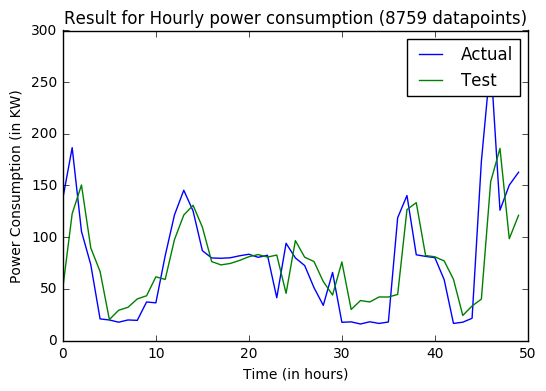

In [30]:
# Plotting of values
plt.plot(scaler.inverse_transform(d1[7050:7100]))
#plt.plot(predtrPlot)
plt.plot(predtePlot[7050:7100])
plt.xlabel('Time (in hours)')
plt.ylabel('Power Consumption (in KW)')
plt.title('Result for Hourly power consumption (%i datapoints)' %(len(d1)))
plt.legend(['Actual','Test'])# loc = 'lower right')
plt.show()
